In [1]:
from torch.utils.data import DataLoader, Subset
from gym_av_aloha.datasets.av_aloha_dataset import AVAlohaDataset
from gaze_av_aloha.policies.gaze_policy.spatial_mdn import (
    SpatialMDN, 
    DistributionHeatmap, 
    gmm_highest_probability_mean,
)
from gaze_av_aloha.policies.gaze_policy.bert import CachedDistilBertEmbedder
from gaze_av_aloha.policies.gaze_policy.utils import denormalize_keypoints, normalize_keypoints
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio
import cv2
from IPython.display import Video, display
import einops
import kornia.augmentation as K
import torch.nn.utils as nn_utils


In [2]:
resize_shape=(240, 320)
unet_cond_dim=768
unet_pretrained=True
unet_n_freeze_layers=1
num_components=1

crop_scale = 0.9

In [3]:
image_keys = [
    "observation.images.zed_cam_left",
]
eye_keys = [
    "left_eye",
]
delta_timestamps = {
    k: [0] for k in image_keys + eye_keys
}
dataset = AVAlohaDataset(
    repo_id="iantc104/av_aloha_sim",
    delta_timestamps=delta_timestamps,
)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_encoder = CachedDistilBertEmbedder().to(device)
mdn = SpatialMDN(
    resize_shape=resize_shape,
    unet_cond_dim=unet_cond_dim,
    unet_pretrained=unet_pretrained,
    unet_n_freeze_layers=unet_n_freeze_layers,
    num_components=num_components,
).to(device)
optimizer = torch.optim.Adam(mdn.parameters(), lr=1e-4)

transforms = K.AugmentationSequential(
    K.RandomCrop(size=(int(resize_shape[0]*crop_scale), int(resize_shape[1]*crop_scale)), p=0.5),
    K.ColorJiggle(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
    K.RandomPerspective(distortion_scale=0.5, p=0.2),
    K.RandomVerticalFlip(p=0.2),
    K.RandomHorizontalFlip(p=0.2),
    K.RandomRotation(degrees=15, p=0.2),
    K.RandomErasing(scale=(0.02, 0.2), ratio=(0.3, 3.3), p=0.2),
    data_keys=["input", "keypoints"],
    same_on_batch=True,
)
normalize = K.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

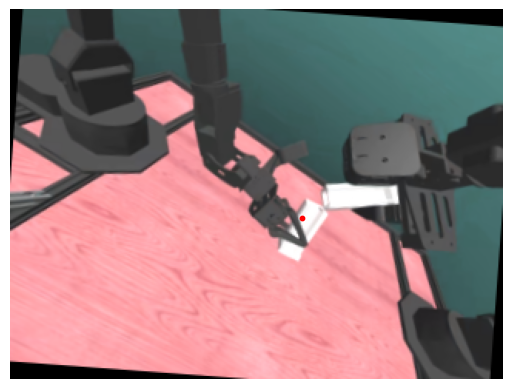

In [5]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)
batch = next(iter(dataloader))
image = batch["observation.images.zed_cam_left"].squeeze(1)
eye = batch["left_eye"]
eye = denormalize_keypoints(eye, image.shape[-2:])
image, eye = transforms(image, eye)
plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
plt.scatter(
    eye[0, 0, 0].cpu().numpy(),
    eye[0, 0, 1].cpu().numpy(),
    c="red",
    s=10,
)
plt.axis("off")
plt.show()

In [ ]:
num_epochs = 5
losses = []
# entropy_weight = 0.001  # Weight for the entropy loss term
for epoch in range(num_epochs):
    mdn.train()
    total_loss = 0.0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in pbar:
        data = {k: v.to(device).squeeze(1) for k, v in batch.items() if k in image_keys + eye_keys}
        data["task"] = batch["task"]
        image = einops.rearrange(
            torch.stack([data[k] for k in image_keys], dim=1),
            'b n c h w -> (b n) c h w', n=len(image_keys)
        )
        eye = einops.rearrange(
            torch.stack([data[k] for k in eye_keys], dim=1),
            'b n e -> (b n) 1 e', n=len(image_keys)
        )
        cond = einops.repeat(
            text_encoder(data["task"]),
            "b d -> (b n) d", n=len(image_keys)
        )

        eye = denormalize_keypoints(eye, image.shape[-2:])
        image, eye = transforms(image, eye)
        eye = normalize_keypoints(eye, image.shape[-2:]).squeeze(1)
        image = normalize(image)
        
        optimizer.zero_grad()
        gmm = mdn(image, cond)
        loss = -gmm.log_prob(eye).mean() #- entropy_weight * gmm_average_entropy(gmm).mean()  # Compute the loss with entropy regularization
        loss.backward()

        # Compute gradient norm
        grad_norm = 0.0
        for p in mdn.parameters():
            if p.grad is not None:
                grad_norm += p.grad.norm().item() ** 2
        grad_norm = grad_norm ** 0.5

        grad_norm = nn_utils.clip_grad_norm_(mdn.parameters(), max_norm=10.0)
      
        optimizer.step()
        total_loss += loss.item() * eye.size(0)

        losses.append(loss.item())

        # Update tqdm progress bar
        pbar.set_postfix(loss=loss.item(), grad_norm=f"{grad_norm:.2f}")

    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")

Epoch 1/5: 100%|██████████| 1228/1228 [04:56<00:00,  4.14it/s, grad_norm=18.95, loss=-2.99] 


Epoch 1 - Avg Loss: -2.8293


Epoch 2/5: 100%|██████████| 1228/1228 [05:10<00:00,  3.95it/s, grad_norm=6.79, loss=-4.13] 


Epoch 2 - Avg Loss: -3.4516


Epoch 3/5: 100%|██████████| 1228/1228 [05:15<00:00,  3.90it/s, grad_norm=7.53, loss=-3.84]  


Epoch 3 - Avg Loss: -3.6194


Epoch 4/5: 100%|██████████| 1228/1228 [05:13<00:00,  3.92it/s, grad_norm=7.65, loss=-3.83]  


Epoch 4 - Avg Loss: -3.7313


Epoch 5/5: 100%|██████████| 1228/1228 [05:17<00:00,  3.87it/s, grad_norm=55.85, loss=-1.02]

Epoch 5 - Avg Loss: -3.8013


In [ ]:
mdn.push_to_hub("iantc104/spatial_mdn_av_aloha_sim_4c")

CommitInfo(commit_url='https://huggingface.co/iantc104/spatial_mdn_av_aloha_sim_4c/commit/f433b82c03fcce127e059789c0618d33d984df55', commit_message='Push model using huggingface_hub.', commit_description='', oid='f433b82c03fcce127e059789c0618d33d984df55', pr_url=None, repo_url=RepoUrl('https://huggingface.co/iantc104/spatial_mdn_av_aloha_sim_4c', endpoint='https://huggingface.co', repo_type='model', repo_id='iantc104/spatial_mdn_av_aloha_sim_4c'), pr_revision=None, pr_num=None)

In [24]:
ranges = [
    [60000, 60500]
]
eval_dataset = Subset(dataset, sum([list(range(start, end)) for start, end in ranges], []))
eval_dataloader = DataLoader(eval_dataset, batch_size=64, shuffle=False)
dist_heatmap = DistributionHeatmap(heatmap_shape=(240, 320)).to(device)


patch_size = 10
topk = 80  # Number of top patches to select
low_res_heatmap = DistributionHeatmap(heatmap_shape=(240 // patch_size, 320 // patch_size)).to(device)

mdn.eval()
video = []
with torch.no_grad():
    for batch in tqdm(eval_dataloader, desc="Evaluation"):
        images = batch["observation.images.zed_cam_left"].to(device).squeeze(1)
        targets = batch["left_eye"].to(device).squeeze(1)
        cond = text_encoder(batch["task"])
        print(cond.shape)
        gmm = mdn(images, cond)
        pred_targets = gmm_highest_probability_mean(gmm)
        pred_sample = gmm.sample((1,)).squeeze(0)  # Sample from the GMM
        heatmaps = dist_heatmap(gmm)  # (B, H, W)

        # Visualize a few examples
        for i in range(images.size(0)):
            img = images[i].cpu()
            img = (img * 255).byte().permute(1, 2, 0).numpy()
            heatmap = heatmaps[i].cpu()
            target = targets[i].cpu()
            px = ((target[0] + 1) / 2) * img.shape[1]
            py = ((target[1] + 1) / 2) * img.shape[0]
            predx = ((pred_targets[i][0] + 1) / 2) * img.shape[1]
            predy = ((pred_targets[i][1] + 1) / 2) * img.shape[0]
            samplex = ((pred_sample[i][0] + 1) / 2) * img.shape[1]
            sampley = ((pred_sample[i][1] + 1) / 2) * img.shape[0]

            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
            heatmap = plt.cm.viridis(heatmap.numpy())  # Apply colormap
            heatmap = (heatmap[:, :, :3] * 255).astype(np.uint8)
            heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
            overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
            overlay = cv2.circle(overlay, (int(px), int(py)), 1, (0, 255, 0), -1)
            overlay = cv2.circle(overlay, (int(predx), int(predy)), 3, (255, 0, 0), -1)
            overlay = cv2.circle(overlay, (int(samplex), int(sampley)), 3, (0, 0, 255), -1)

            video.append(overlay)

# Save video
video_path = "mdn_saliency_video.mp4"
imageio.mimwrite(video_path, video, fps=25)

# Display video in Jupyter
display(Video(video_path, embed=True, width=512, height=384))


Evaluation:   0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([64, 768])


Evaluation:  12%|█▎        | 1/8 [00:00<00:02,  2.91it/s]

torch.Size([64, 768])


Evaluation:  25%|██▌       | 2/8 [00:00<00:01,  3.28it/s]

torch.Size([64, 768])


Evaluation:  38%|███▊      | 3/8 [00:00<00:01,  3.46it/s]

torch.Size([64, 768])


Evaluation:  50%|█████     | 4/8 [00:01<00:01,  3.56it/s]

torch.Size([64, 768])


Evaluation:  62%|██████▎   | 5/8 [00:01<00:00,  3.41it/s]

torch.Size([64, 768])


Evaluation:  75%|███████▌  | 6/8 [00:01<00:00,  3.51it/s]

torch.Size([64, 768])


Evaluation:  88%|████████▊ | 7/8 [00:02<00:00,  3.38it/s]

torch.Size([52, 768])


KeyboardInterrupt: 

In [14]:
gmm.sample((2,)).shape

torch.Size([2, 24, 2])

In [22]:
mdn = mdn.from_pretrained("iantc104/spatial_mdn_av_aloha_sim_1c").to(device)

config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/74.4M [00:00<?, ?B/s]

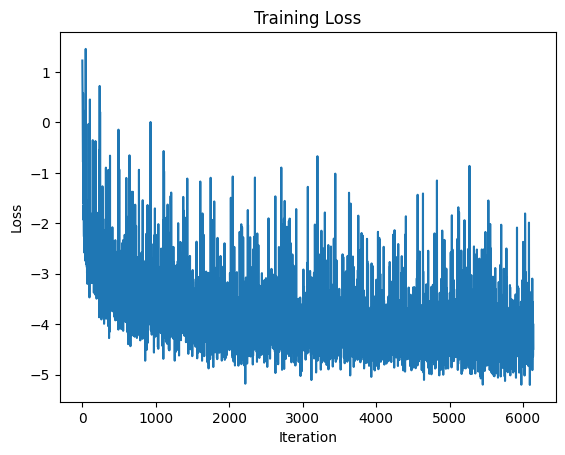

In [26]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()